# Modelado – Predicción de Consumo Eléctrico
Modelos baseline, modelos avanzados, tuning y evaluación.


In [5]:
print("Entrenamiento baseline listo para implementar")


Entrenamiento baseline listo para implementar


In [6]:
# ============================================
#   PROYECTO A — MODELOS DE PRONÓSTICO
# ============================================

# -----------------------
# 1. Importar librerías
# -----------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

plt.style.use("default")

# -----------------------
# 2. Cargar dataset
# -----------------------
df = pd.read_csv("../data/consumo_sintetico.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp")

df.head()


,consumo,temperatura
timestamp,,
2023-01-01 00:00:00,206.8768,15.9934
2023-01-01 01:00:00,204.5297,14.7235
2023-01-01 02:00:00,205.1761,16.2954
2023-01-01 03:00:00,212.8985,18.0461
2023-01-01 04:00:00,223.4037,14.5317


In [7]:
# -----------------------
# 3. Features basadas en tiempo
# -----------------------
df["hora"] = df.index.hour
df["dia_semana"] = df.index.dayofweek
df["mes"] = df.index.month
df["dia"] = df.index.day
df["año"] = df.index.year

# Lag features
df["lag_1"] = df["consumo"].shift(1)
df["lag_24"] = df["consumo"].shift(24)
df["lag_168"] = df["consumo"].shift(168)   # 7 days lag

df = df.dropna()


In [8]:
# -----------------------
# 4. Train-test split temporal
# -----------------------
train = df.iloc[:-24*30]   # últimos 30 días como test
test = df.iloc[-24*30:]

X_train = train.drop("consumo", axis=1)
y_train = train["consumo"]
X_test = test.drop("consumo", axis=1)
y_test = test["consumo"]

(len(train), len(test))


(7872, 720)

NAIVE — MAE: 10.14815875
NAIVE — RMSE: 12.915578204974775


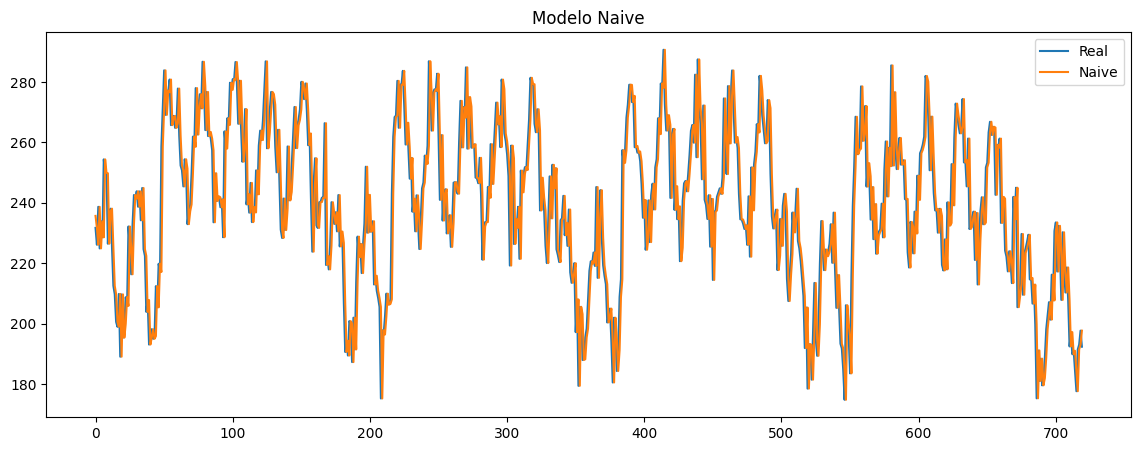

In [9]:
# -----------------------
# 5. Modelo Naive
# -----------------------
y_pred_naive = test["lag_1"]

mae = mean_absolute_error(y_test, y_pred_naive)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_naive))

print("NAIVE — MAE:", mae)
print("NAIVE — RMSE:", rmse)

plt.figure(figsize=(14,5))
plt.plot(y_test.reset_index(drop=True), label="Real")
plt.plot(y_pred_naive.reset_index(drop=True), label="Naive")
plt.legend()
plt.title("Modelo Naive")
plt.show()


RF — MAE: 5.753056743055562
RF — RMSE: 7.354500646786115


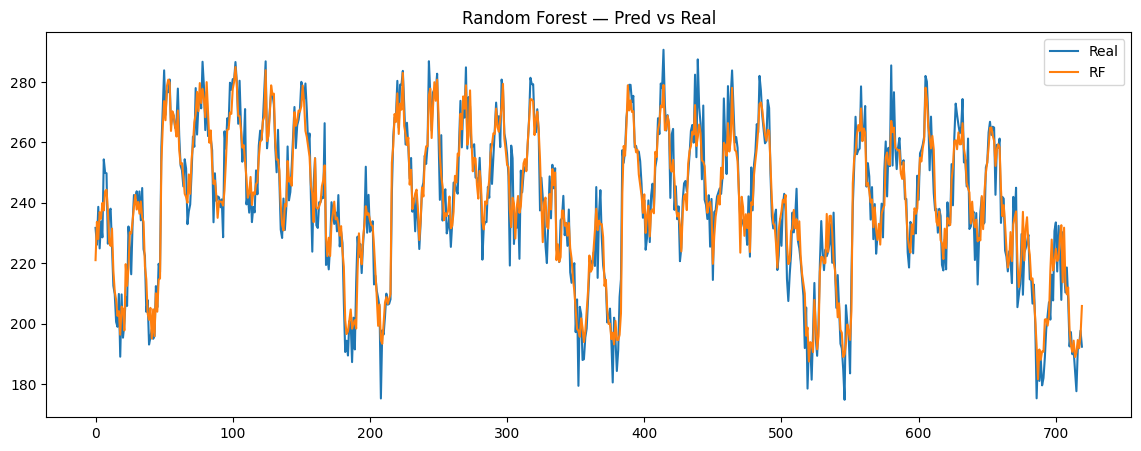

In [10]:
# -----------------------
# 6. Random Forest
# -----------------------
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("RF — MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RF — RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

plt.figure(figsize=(14,5))
plt.plot(y_test.reset_index(drop=True), label="Real")
plt.plot(y_pred_rf, label="RF")
plt.legend()
plt.title("Random Forest — Pred vs Real")
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1096
[LightGBM] [Info] Number of data points in the train set: 7872, number of used features: 8
[LightGBM] [Info] Start training from score 233.031482
LGBM — MAE: 4.733105279983488
LGBM — RMSE: 6.038331943643832


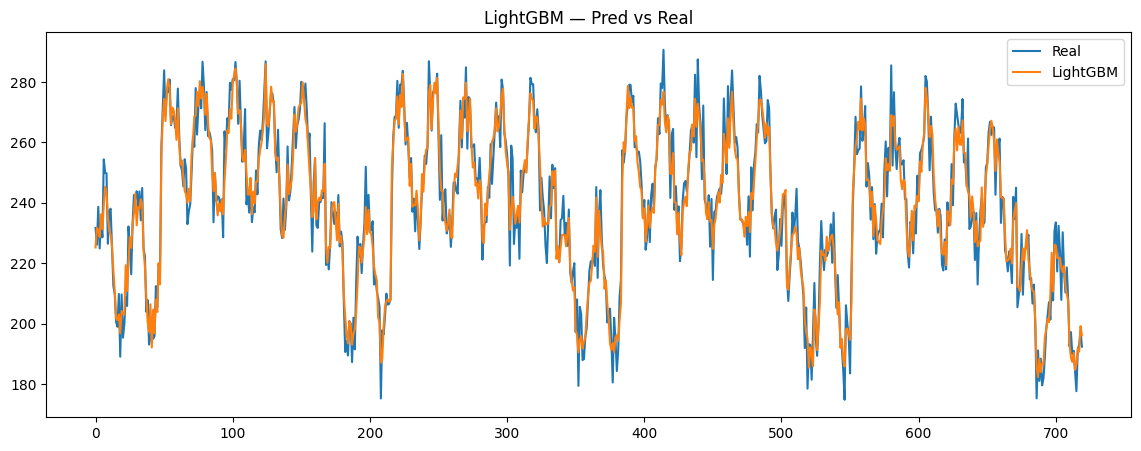

In [11]:
# -----------------------
# 7. LightGBM
# -----------------------
lgbm = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.02)
lgbm.fit(X_train, y_train)

y_pred_lgb = lgbm.predict(X_test)

print("LGBM — MAE:", mean_absolute_error(y_test, y_pred_lgb))
print("LGBM — RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgb)))

plt.figure(figsize=(14,5))
plt.plot(y_test.reset_index(drop=True), label="Real")
plt.plot(y_pred_lgb, label="LightGBM")
plt.legend()
plt.title("LightGBM — Pred vs Real")
plt.show()


In [12]:
# -----------------------
# 8. Comparación de todos los modelos
# -----------------------
results = pd.DataFrame({
    "MAE": [
        mean_absolute_error(y_test, y_pred_naive),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_lgb)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_naive)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_lgb))
    ]
}, index=["Naive", "RandomForest", "LightGBM"])

results


,MAE,RMSE
Naive,10.148159,12.915578
RandomForest,5.753057,7.354501
LightGBM,4.733105,6.038332
